# Lorenz attractor

In [1]:
import numpy as np

In [2]:
sigma = 10
beta = 8 / 3
ro = 28

X = np.array([1, 1, 1])
params = np.array([sigma, beta, ro])

In [3]:
def d_dt(X, params):
    sigma, beta, ro = params
    return np.array([
        sigma * (X[1] - X[0]),
        X[0] * (ro - X[2]) - X[1],
        X[0] * X[1] - beta * X[2]
    ])

In [4]:
def step(X, params, t):
    return X + t * d_dt(X, params)

In [5]:
def get_lorenz_coords(X, params=params, n_coords=30000, t=0.0001):
    # coords = np.array([X])
    coords = []
    for i in range(n_coords):
        X = step(X, params, t)
        # coords = np.append(coords, [X], axis=0)
        coords.append(X)
    return np.array(coords)

In [6]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_lorenz(coordsets, coordset_labels=None):
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111, projection='3d')
    generated_legend = []
        
    for i, coords in enumerate(coordsets):
        ax.plot(xs = coords[:,0], ys = coords[:,1], zs = coords[:,2], linewidth=0.75)
        generated_legend.append(i)
    if coordset_labels:
        plt.legend(coordset_labels)
    else:
        plt.legend(generated_legend)
        
def plot_X_vs_t(coordsets, t):
    fig = plt.figure(figsize=[10,5])
    start_t = 0
    legend = []
    for i, coordset in enumerate(coordsets):
        t_values = np.array([start_t + n * t for n in range(len(coordset))])
        start_t = t_values[-1]
        print(t_values)
        plt.plot(t_values, coordset[:,0])
        plt.plot(t_values, coordset[:,1])
        plt.plot(t_values, coordset[:,2])
        legend.extend([f"x_{i}", f"y_{i}", f"z_{i}"])
    plt.legend(legend)

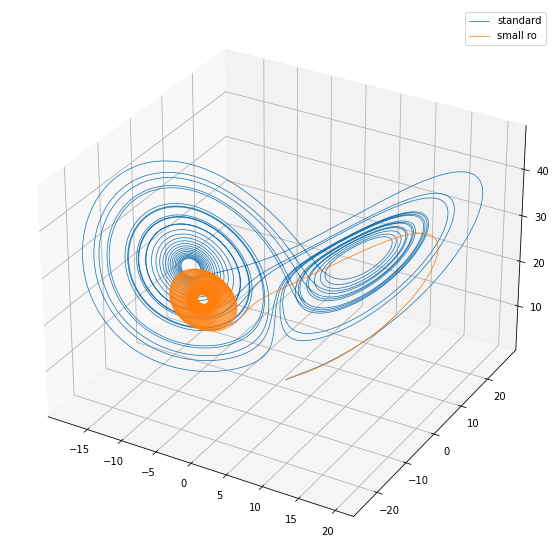

In [7]:
t = 0.001
n_coords = 30000

coords = get_lorenz_coords(X, params, n_coords, t)
# For smaller values of ro, we instead find that we have a fixed point attractor. 
# (Note that the choice of t seems to cause some degree of error, e.g. I was unable to get po = 23 to produce a fixed point)
coords_2 = get_lorenz_coords(X, [params[0], params[1], 21], n_coords, t)

plot_lorenz([coords, coords_2], ["standard", "small ro"])
# I think that we should see minimal change by shifting the starting point and mostly from choosing different parameters

[0.0000e+00 1.0000e-03 2.0000e-03 ... 2.9997e+01 2.9998e+01 2.9999e+01]
[0.0000e+00 1.0000e-03 2.0000e-03 ... 2.9997e+01 2.9998e+01 2.9999e+01]


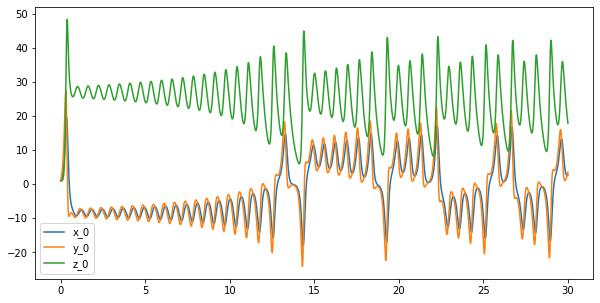

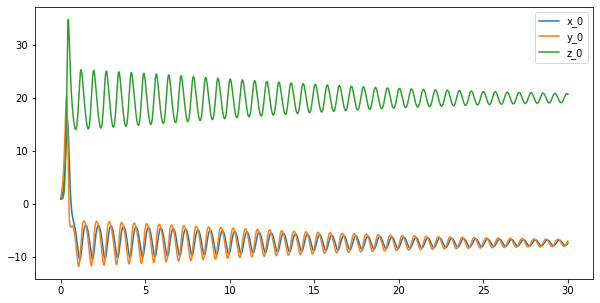

In [8]:
plot_X_vs_t([coords], t)
plot_X_vs_t([coords_2], t)

# Build the reservoir network

In [9]:
import scipy.linalg

In [10]:
N = 450
M = len(X) # 3
p = 0.1 # reservoir initial density
alpha = 0.95 
sig = 0.008 # % "attractor influence"
control_param = 0.004 # % "control parameter"

# I copied this out of the code for the Kim paper, which (mostly) follows
# the process of generating W from this paper by Jaeger (author of original ESN paper)
# https://www.cse.iitk.ac.in/users/hk/cs671/201617/details/rnnTutorialJaeger.pdf
A = (np.random.random([N,N]) - 0.5) * 2
A = A * (np.random.random([N,N]) < p)

# For some reason they compute the max of the real components instead of absolute values.
# Doesn't seem to change the value of the spectral radius much. I changed it to follow Jaeger.
# spectral_radius = np.max(np.real(scipy.linalg.eigvals(A)))
spectral_radius = np.max(np.abs(scipy.linalg.eigvals(A)))
A = (A / spectral_radius) * alpha
A.shape

# Jaeger pretty much says "use whatever you want" for the input matrix, the paper used this method:
B = 2 * sig * (np.random.random([N,M]) * 0.5) 
C = 2 * control_param * (np.random.random([N]) - 0.5)

# If our network is an echo state network (which it should be as we followed the correct procedure
# for defining A) then r0 theoretically shouldn't matter. 
# Unclear if it is important in practice.

# % "Distribution of offsets"
# Apparently this is only used to compute d
# The code claims it to be the reservoir fixed point
r0 = (np.random.random([N]) * 0.2 + 0.8) * np.sign(np.random.random([N]) - 0.5)  

d = np.arctanh(r0) - A @ r0 # This is what they give in the supplementary material, in the code
# it includes a few more things. 

r = np.zeros_like(r0)
r.shape

(450,)

In [11]:
# from previous section
xs = coords
xs.shape

(30000, 3)

In [12]:
# Our update rule is given by:
# r_next = g(Ar + Bx + d)

def train(xs, r, cs=None):
    rs = []
    if cs is None:
        for x in xs:
            z = A @ r + B @ x + d
            r = np.tanh(z)
            rs.append(r)
    else:        
        for x, c in zip(xs, cs):
            z = A @ r + B @ x + C * c + d
            r = np.tanh(z)
            rs.append(r)
    rs = np.array(rs)
    return rs

In [13]:
rs = train(xs, r)

In [14]:
rs.shape, rs[-1].shape

((30000, 450), (450,))

In [15]:
# Apparently if you decompose r using PCA, it will reflect the toplogy of the inputs
# Let's try it out
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
rs_pca = pca.fit_transform(rs)
print(pca.explained_variance_ratio_)

[0.91708896 0.05834956 0.01360397]


### Wow, when we project r into 3-space using PCA, it looks just like the Lorenz input!

[0.0000e+00 1.0000e-03 2.0000e-03 ... 2.9997e+01 2.9998e+01 2.9999e+01]


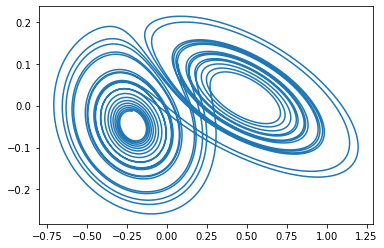

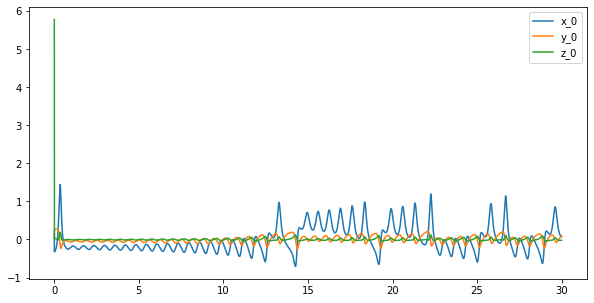

In [16]:
plt.plot(rs_pca[5000:,0], rs_pca[5000:,1])
# plot_lorenz([rs_pca[500:]]) # Not as pretty
plot_X_vs_t([rs_pca], t)

### Train the output matrix W, then apply this to the reservoir states to generate predicted Lorenz coords

In [17]:
xs.shape, rs.shape

((30000, 3), (30000, 450))

In [18]:
# import torch

In [19]:
# W = torch.rand([450, 3], dtype=torch.float64, requires_grad=True)
# xs_tensor = torch.tensor(xs)
# rs_tensor = torch.tensor(rs)

In [20]:
# loss = torch.linalg.norm((rs_tensor @ W) - xs_tensor)
# loss.backward()
# W.grad

In [21]:
# IT IS VERY IMPORTANT HERE THAT WE SHIFT THE ARRAYS
# We want R_(n) to predict X_(n+1).
# This way we learn to predict the NEXT value of the sequence.
# I originally had R_n predicting X_n, which results in something that
# can only predict the value of the sequence that was just fed in - i.e. useless for generating
# new predictions of the Lorenz sequence. 
W = np.linalg.lstsq(rs[:-1], xs[1:], rcond=None)[0]
W.shape

(450, 3)

In [22]:
xs_hat = ((rs @ W))
xs_hat.shape

(30000, 3)

### Sick, it works

~~Very interesting, the output is practically IDENTICAL to the input.~~
This is exactly as expected: we are able to use the reservoir values (rs) to
predict each of the x values that they were trained on. Not generating any new data,
just predicting the training data. 

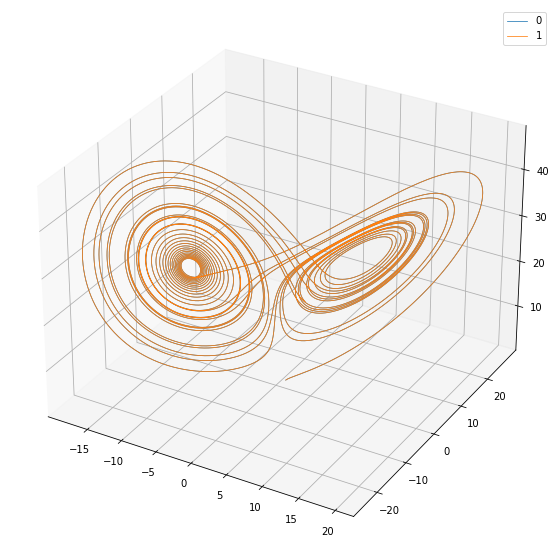

In [23]:
plot_lorenz([xs, xs_hat])

In [26]:
# # This gives me confidence that we doing something right here, can't just find a linear mapping from noise to xs
# fake_rs = np.random.random(rs.shape)
# fake_W = np.linalg.lstsq(fake_rs, xs, rcond=None)[0]
# fake_xs_hat  = ((fake_rs @ fake_W))
# plot_lorenz([fake_xs_hat])

### Let's try feeding it back into itself

In [27]:
rs.shape

(30000, 450)

In [28]:
xs_hat.shape, rs[-1].shape

((30000, 3), (450,))

In [29]:
# Here we generate a whole new crop of xs at once by taking rs @ W and feeding that back into train()

rs_2 = train(xs_hat, rs[-1])
rs_2.shape

# It makes no sense to do this, because this is effectively trying to re-predict every single x that we've ALREADY
# given the reservoir. It's able to do this just fine, but this doesn't give us a way of predicting NEW data in the
# Lorenz sequence. 

# So what we're doing is predicting all the original x values (quite well) and then training the reservoir again on those
# predicted x values (which were close to the original) and then making a second prediction of what the previously predicted
# values were. 

(30000, 450)

In [30]:
# plot_lorenz([rs_2 @ W])

In [31]:
(rs_2 @ W).shape

(30000, 3)

(1, 450) (450, 3) (1, 3)
[0.0000e+00 1.0000e-03 2.0000e-03 ... 2.9997e+01 2.9998e+01 2.9999e+01]
[29.999 30.    30.001 ... 59.996 59.997 59.998]


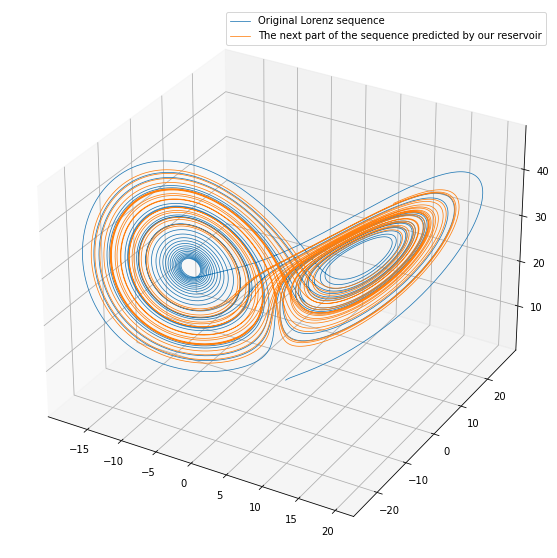

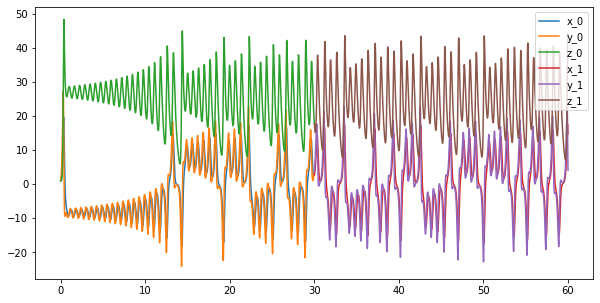

In [32]:
# Generate a new sequence of Lorenz values from our reservoir, one at a time,
# starting from the value r had after we finished driving the reservoir on the 
# original xs and using our newly trained W. 

def generate_new_seq(r, W, seq_length=30000, c=None):
    r_new = np.expand_dims(r, axis=0)
    x_hat = r_new @ W
    print(r_new.shape, W.shape, x_hat.shape)

    x_hats = []
    for i in range(seq_length):
        # Train will output an array of rs, so when we feed it back in we index it to just give it one.
        # When we feed back in next time,
        # train is expecting an array of xs, so we keep r_new as a 1xN array rather than indexing.
        if c is None:
            r_new = train(x_hat, r_new[-1])
        else:
            r_new = train(x_hat, r_new[-1], np.expand_dims(c, axis=1))
        x_hat = r_new @ W
        x_hats.append(x_hat)

    return np.concatenate(x_hats, axis=0) # should probably return r 

x_hats = generate_new_seq(rs[-1], W)

plot_lorenz([xs, x_hats], ["Original Lorenz sequence", "The next part of the sequence predicted by our reservoir"])
plot_X_vs_t([xs, x_hats], t)

### Let's try learning translation

In [33]:
P = np.array([1,0,0])

In [34]:
# c_range = (0, 4)
c_range = (0, 100) # this makes for something very interesting...

# Continuously vary c:
cs = [i / len(xs) * (c_range[1] - c_range[0]) + c_range[0] for i in range(len(xs))]

# Increment c by integer value at specific points in time:
# cs = [int(c) for c in cs]

cs = np.array(cs)
cs = np.expand_dims(cs, axis=1)
cs.shape

(30000, 1)

In [35]:
xs_shifted = xs + P * cs
xs_shifted.shape

(30000, 3)

In [36]:
r_start = r # original r from when we initialized everything in the first section
rs_shifted = train(xs_shifted, r_start, cs)
rs_shifted.shape

(30000, 450)

In [37]:
W_shifted = np.linalg.lstsq(rs_shifted[:-1], xs_shifted[1:], rcond=None)[0]
W_shifted.shape

(450, 3)

In [38]:
xs_shifted_hat = rs_shifted @ W_shifted

[0.0000e+00 1.0000e-03 2.0000e-03 ... 2.9997e+01 2.9998e+01 2.9999e+01]


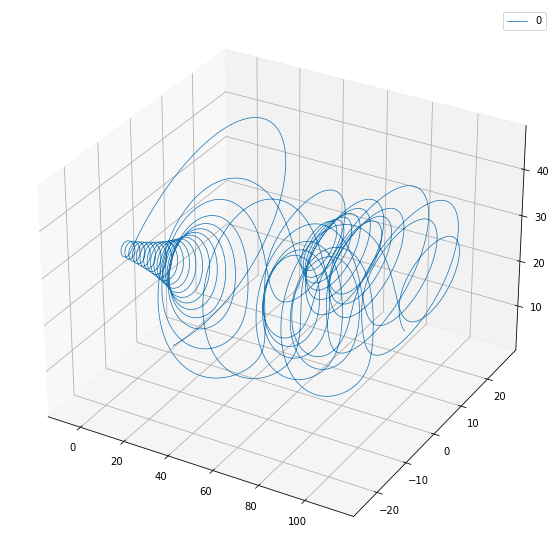

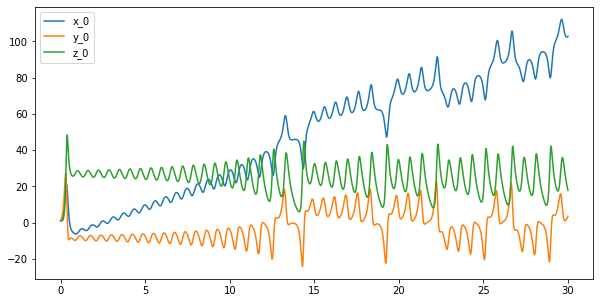

In [39]:
plot_lorenz([xs_shifted_hat])
plot_X_vs_t([xs_shifted_hat], t)

### It works! Can see how it breaks down for values of c that go too far beyond training

(1, 450) (450, 3) (1, 3)
(1, 450) (450, 3) (1, 3)


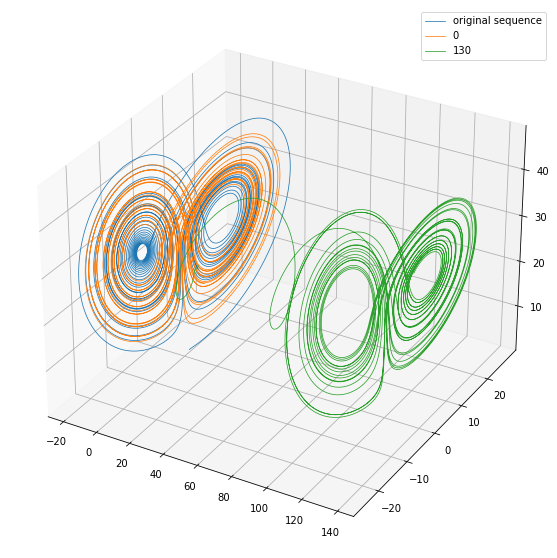

In [40]:
plot_lorenz([
    xs,
    generate_new_seq(rs[-1], W_shifted, c=np.array([0])),
    generate_new_seq(rs[-1], W_shifted, c=np.array([120])),
], ["original sequence", "0", "130"])

(1, 450) (450, 3) (1, 3)
(1, 450) (450, 3) (1, 3)
(1, 450) (450, 3) (1, 3)
(1, 450) (450, 3) (1, 3)


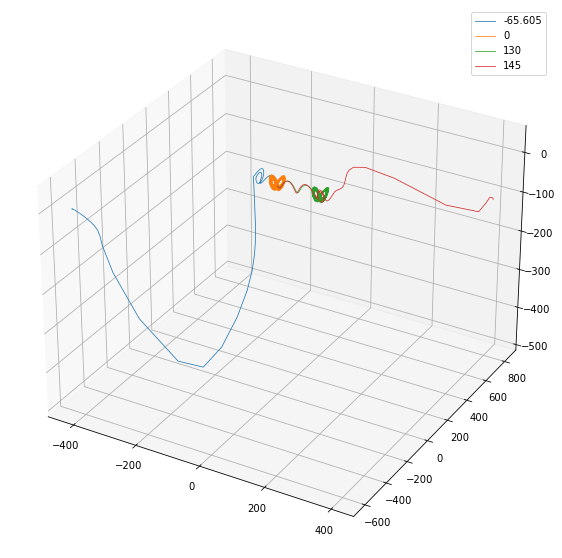

In [41]:
# So it still destabilizes after going beyond about 40 past the c value that it was trained on
# Note: As the reservoir is randomly initialized this can vary from run to run.
# Try playing around with the values of c. 
plot_lorenz([
    generate_new_seq(rs[-1], W_shifted, c=np.array([-65.605])), # couldn't get a nice value where you can see that it's clearly fucked
    generate_new_seq(rs[-1], W_shifted, c=np.array([0])),
    generate_new_seq(rs[-1], W_shifted, c=np.array([130])),
    generate_new_seq(rs[-1], W_shifted, c=np.array([145])),
], ["-65.605", "0", "130", "145"])

In [42]:
# So we were able to get it to work, but only by continuously varying the value of c 
# rather than shifting everything at once like they said in the paper.
# It appears that if we abruptly change the value of c (therefore abruptly moving the coords in the middle of the sequence)
# the sequence generator will not work correctly
# (Can try this by uncommenting the line where I make cs integers)

old

In [752]:
# rs_i = []
# for i, c in enumerate(c_i):
#     rs_i.append(train(xs_i[i], r_start, c))
#     r_start = rs_i[-1][0]

In [754]:
# xs_i_concat = np.concatenate(xs_i)
# rs_i_concat = np.concatenate(rs_i)
# xs_i_concat.shape, rs_i_concat.shape, cs_i_concat.shape

In [755]:
# W_i_concat = np.linalg.lstsq(rs_i_concat[:-1], xs_i_concat[1:], rcond=None)[0]
# W_i_concat.shape

In [757]:
# xs_i_concat_hat = ((rs_i_concat @ W_i_concat))
# xs_i_concat_hat.shape